In [1]:
user = "Alex"
pathtorepo = "C:\\Users\\" * user * "\\Desktop\\"

using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")
include("C:\\Users\\" * user * "\\Desktop\\dynamical-systems\\system.jl")
;

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`

In [2]:
using StaticArrays, DifferentialEquations, DynamicalSystems, LinearAlgebra
E, x, y = 0..30, 0..1, 0..1
box = E × x × y
using CairoMakie, GLMakie

In [17]:
const τ = 0.013;  const τD = 0.07993;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4
const α = 1.58; const ΔU0 = 0.305; 

@inbounds function TM_DAE(du, u, p, t)
    U(y, p) = p[8] + p[9] / ( 1.0 + exp( -50.0 * (y - p[7]) ) )
    σ(x, p) = 1.0 / ( 1.0 + exp( -20.0 * (x-p[6]) ) )
    g(E, x, y, p, U_) = log( 1.0 + exp( (p[5] * U_ * x * E + p[11]  ) / (p[1]) ) )
    
    U_ = U(u[3], p)
    du[1] = (-u[1] + p[1] * g(u[1], u[2], u[3], p, U_) )# / p[2]
    du[2] = (1.0 - u[2]) / p[3] - U_*u[2]*u[1]
    du[3] = (-u[3])/p[4] + p[10] * σ(u[2], p)
    
    nothing
end

M = [ τ 0.0 0.0
    0.0 1.0 0.0
    0.0 0.0 1.0]

3×3 Matrix{Float64}:
 0.013  0.0  0.0
 0.0    1.0  0.0
 0.0    0.0  1.0

In [18]:
tstart = 0.0; tend = 100.0; tspan = (tstart, tend)

(0.0, 100.0)

In [19]:
I0 = -1.7064; U0 = 0.265;
p = [α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]
u0 = [8.254587677389917, 0.7099299111721875, 0.549798431121074]

3-element Vector{Float64}:
 8.254587677389917
 0.7099299111721875
 0.549798431121074

In [20]:
ds = CoupledODEs(TM, u0, p)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  TM
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [1.58, 0.013, 0.07993, 3.3, 3.07, 0.75, 0.4, 0.265, 0.305, 0.3, -1.7064]
 time:          0.0
 state:         [8.254587677389917, 0.7099299111721875, 0.549798431121074]


In [21]:
fp, ei, _ = fixedpoints(ds, box, jacob_TM_);
Jac = jacob_TM_(fp[1], p, 0)
eivecs = eigvecs(Jac)
shift = real(eivecs[:, 1])*1e-9 + fp[1]

3-element SVector{3, Float64} with indices SOneTo(3):
 8.345676550765564
 0.7384954219049725
 0.43830225982207927

In [22]:
f = ODEFunction(TM_DAE, mass_matrix = M)

(::ODEFunction{true, SciMLBase.FullSpecialize, typeof(TM_DAE), Matrix{Float64}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}) (generic function with 1 method)

In [23]:
prob = ODEProblem(f, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 3-element Vector{Float64}:
 8.254587677389917
 0.7099299111721875
 0.549798431121074

In [29]:
sol = solve(prob, alg = GRK4T(), reltol = 1e-8, abstol = 1e-10)

retcode: Success
Interpolation: 3rd order Hermite
t: 26812-element Vector{Float64}:
   0.0
   1.0e-6
   1.1e-5
   0.00011099999999999999
   0.0006525917142301441
   0.001575058376892848
   0.00276029169787322
   0.0042189235516004705
   0.005787855022504387
   0.007494148312823327
   ⋮
  99.96961906259907
  99.97383726703282
  99.97805547146658
  99.98227367590033
  99.98649188033409
  99.99071008476784
  99.9949282892016
  99.99914649363535
 100.0
u: 26812-element Vector{Vector{Float64}}:
 [8.254587677389917, 0.7099299111721875, 0.549798431121074]
 [8.254610580516966, 0.7099302009127499, 0.5497983574334093]
 [8.254839652268776, 0.7099330975346504, 0.5497976205784295]
 [8.257134417845513, 0.7099619853690157, 0.5497902541917254]
 [8.269690538098297, 0.7101159611274109, 0.5497504261172165]
 [8.291573560575515, 0.7103685670896461, 0.5496828456724187]
 [8.320608371366509, 0.7106752082217817, 0.5495964700735545]
 [8.357756883226568, 0.7110247885900886, 0.5494908317222601]
 [8.39945615108288

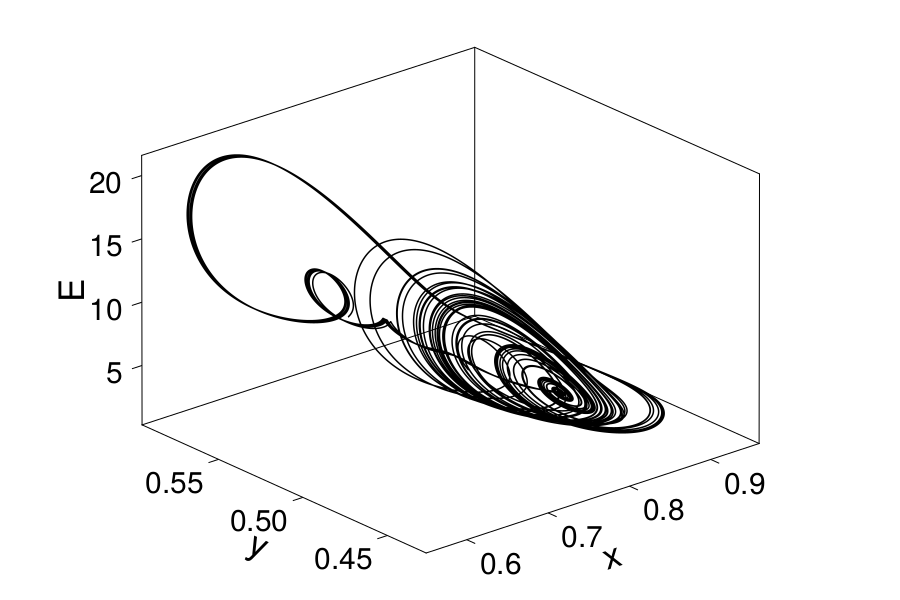

CairoMakie.Screen{IMAGE}


In [31]:
ts, tf = 1, 20000
indexx,indexy,indexz = 2, 3, 1
lb_size = 35; tck_size = 30;

CairoMakie.activate!()
f = Figure(resolution = (900, 600))
axis3 = Axis3(f[1, 1], xlabel = "x", ylabel = "y", zlabel = "E",
                xlabelsize = lb_size, ylabelsize = lb_size, zlabelsize = lb_size,
                xticklabelsize = tck_size, yticklabelsize = tck_size, zticklabelsize = tck_size,
                xgridvisible = false, ygridvisible = false, zgridvisible = false)



lines!(axis3, sol[indexx, ts:tf], sol[indexy, ts:tf], sol[indexz, ts:tf], linewidth = 1.5, color = :black)
display(f)